In [1]:
# Copyright (C) 2020 Luceda Photonics
# Modified by Ongun Arisev (ongunarisev@gmail.com)

from siepic import all as pdk
from ipkiss3 import all as i3
import pylab as plt
import numpy as np
from math import sin, pi


In [2]:
def get_angle(straight_length, delay_length, initial_angle):

    total_length = straight_length + delay_length
    initial_angle_rad = initial_angle * pi / 180.0

    def f(angle_rad):
        return abs(angle_rad / sin(angle_rad) - total_length / straight_length)

    from scipy.optimize import minimize

    res = minimize(
        f,
        x0=initial_angle_rad,
        bounds=((0, pi / 2),),
    ).x[0]
    angle = abs(res) * 180.0 / pi

    return angle

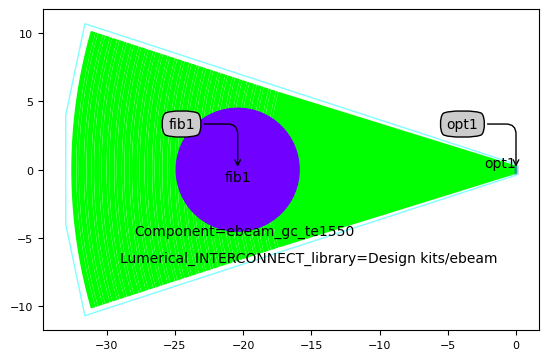

In [3]:
# 1. First, we instantiate the Y-branch from the SiEPICfab PDK.
splitter = pdk.EbeamY1550()
splitter_tt = splitter.Layout().ports["opt2"].trace_template

# 2. We instantiate the waveguides we will use for eth arms of the MZI.
straight_length = 200.0
delay_length = 20.0
bump_angle = get_angle(straight_length=straight_length, delay_length=delay_length, initial_angle=10.0)

wg_straight = pdk.WaveguideStraight(wg_length=straight_length, trace_template=splitter_tt)
wg_bump = pdk.WaveguideBump(x_offset=straight_length, angle=bump_angle, trace_template=splitter_tt)

# 3. We instantiate the fiber grating coupler.
fgc = pdk.EbeamGCTE1550()
fgc.Layout().visualize(annotate=True)

# 4. We snap the ports to each other by using `i3.Join`.
# Other placement specifications define all the transformations that apply to each instance.
insts = {
    "yb_1": splitter,
    "yb_2": splitter,
    "wg_up": wg_bump,
    "wg_down": wg_straight,
    "fgc_1": fgc,
    "fgc_2": fgc,
}

# 5. We define specs, containing all the transformations that apply to each component.
specs = [
    i3.Join("fgc_1:opt1", "yb_1:opt1"),
    i3.Join("yb_1:opt2", "wg_up:pin1"),
    i3.Join("wg_up:pin2", "yb_2:opt2"),
    i3.Join("yb_1:opt3", "wg_down:pin1"),
    i3.Join("wg_down:pin2", "yb_2:opt3"),
    i3.Join("yb_2:opt1", "fgc_2:opt1"),
    i3.Place("yb_1:opt1", (0, 0)),
    i3.FlipH("yb_2"),
    i3.FlipH("fgc_2"),
]

# 6. We define the names of the exposed ports that we want to access.
exposed_port_names = {
    "fgc_1:fib1": "in",
    "fgc_2:fib1": "out",
}

# 7. We instantiate the i3.Circuit class to create the circuit.
mzi = i3.Circuit(
    name="mzi",
    insts=insts,
    specs=specs,
    exposed_ports=exposed_port_names,
)


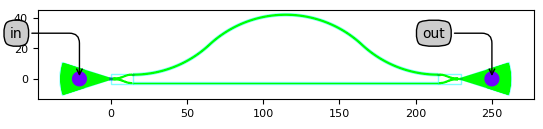

C:\Users\ongun\PycharmProjects\ipkiss_training\mzi_with_ybranch.gds

In [4]:
# Layout
mzi_layout = mzi.Layout()
mzi_layout.visualize(annotate=True)
mzi_layout.write_gdsii("mzi_with_ybranch.gds")

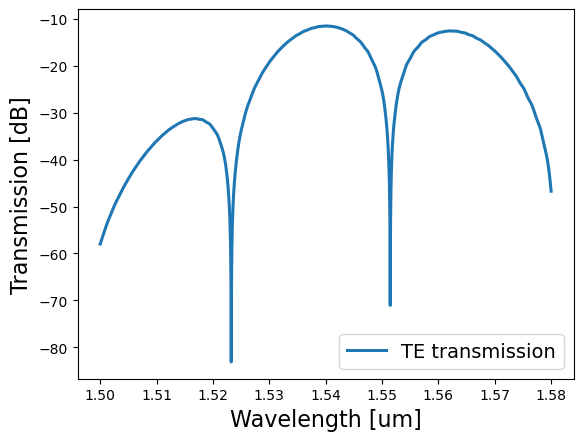

In [6]:
# Circuit model
mzi_cm = mzi.CircuitModel()
wavelengths = np.linspace(1.50, 1.58, 8001)
S_total = mzi_cm.get_smatrix(wavelengths=wavelengths)

# Plotting
plt.plot(wavelengths, i3.signal_power_dB(S_total["out:0", "in:0"]), "-", linewidth=2.2, label="TE transmission")
plt.xlabel("Wavelength [um]", fontsize=16)
plt.ylabel("Transmission [dB]", fontsize=16)
plt.legend(fontsize=14, loc=4)
plt.show()
